In [1]:
import numpy as np
import pandas as pd
import os
import math
from operator import truediv
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.modules.loss import _Loss
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)


windowSize = 25
batch_size = 64

In [4]:
def padding(X, margin=2):
    newX = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX [x_offset : X.shape[0] + x_offset, y_offset : X.shape[1] + y_offset, :] = X
    return newX

def createPatch(X, y, windowSize=windowSize):
    margin = int((windowSize-1)/2)
    zeroPaddedX = padding(X, margin=margin)

    patchesData = np.zeros((X.shape[0]*X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0

    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin: r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex += 1


    patchesData = patchesData[patchesLabels > 0, :, :, :]
    patchesLabels = patchesLabels[patchesLabels > 0]
    patchesLabels -= 1


    patchesData = patchesData.transpose((0, 3, 1, 2))

    return patchesData, patchesLabels


def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX

In [5]:
def splitTrainTestSet(X, y, randomState=42):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# **VERİ YÜKLEME VE ÖNİŞLEMLER**

In [6]:
X = np.load('/content/drive/MyDrive/dml/indian-veriseti/indianpinearray.npy')
y = np.load('/content/drive/MyDrive/dml/indian-veriseti/IPgt.npy')

In [7]:
X=applyPCA(X)

X.shape

(145, 145, 15)

In [8]:
X,y=createPatch(X,y)

In [9]:
X.shape

(10249, 15, 25, 25)

# **BURASI TRİPLET İÇİN**

In [ ]:
X_df = pd.DataFrame(X.reshape(X.shape[0], -1))

In [ ]:
df = pd.DataFrame(X.reshape(X.shape[0], -1))

In [ ]:
df['class'] = y.ravel()

In [ ]:
y_df= df['class']

In [ ]:
X_train_df,X_val_df,X_test_df,y_train_df,y_val_df,y_test_df=splitTrainTestSet(X_df,y_df)

In [ ]:
X_train_df.shape

(3074, 9375)

In [ ]:
columns = ['archor_img','postive_img','close_positive_img','negative_img','label']
df_train_for_triplet=pd.DataFrame(columns=columns)
df_test_for_triplet=pd.DataFrame(columns=columns)
df_val_for_triplet=pd.DataFrame(columns=columns)

val_df=pd.concat([X_val_df,y_val_df],axis=1)
train_df=pd.concat([X_train_df, y_train_df], axis=1)
test_df=pd.concat([X_test_df,y_test_df],axis=1)

In [ ]:
train_df.shape

(3074, 9376)

In [ ]:
train_df_reset_index= train_df.reset_index()
test_df_reset_index = test_df.reset_index()
val_df_reset_index = val_df.reset_index()

In [ ]:
train_df_reset_index.shape

(3074, 9377)

In [ ]:
test_df_reset_index.shape

(2870, 9377)

In [ ]:
for index, row in train_df_reset_index.iterrows():
       label= row['class']
       archor_img = row['index']
       index_2 = index+1;
       while(index_2 <train_df_reset_index.shape[0]-1 and train_df_reset_index.iloc[index_2]['class'] != label ):
              index_2 = index_2 + 1

       if(index_2 <train_df_reset_index.shape[0]-1):
            positive = train_df_reset_index.iloc[index_2]['index']
            c=np.random.randint(1,train_df_reset_index.shape[0])
            while(train_df_reset_index.iloc[c]['class']==label):
                c=np.random.randint(1,train_df_reset_index.shape[0])
            negative = train_df_reset_index.iloc[c]['index']
            new_row_dict = {'archor_img': archor_img, 'postive_img': archor_img, 'close_positive_img':positive, 'negative_img': negative, 'label': label}
            df_train_for_triplet=df_train_for_triplet._append(new_row_dict, ignore_index=True)

In [ ]:
df_train_for_triplet

,archor_img,postive_img,close_positive_img,negative_img,label
0,3134.0,3134.0,10081.0,2779.0,9.0
1,5160.0,5160.0,1474.0,5659.0,1.0
2,6990.0,6990.0,8179.0,3403.0,10.0
3,8179.0,8179.0,7999.0,2528.0,10.0
4,5275.0,5275.0,9632.0,8322.0,2.0
...,...,...,...,...,...
3052,5311.0,5311.0,5578.0,2097.0,10.0
3053,6949.0,6949.0,6265.0,8105.0,4.0
3054,1685.0,1685.0,5390.0,3712.0,1.0
3055,8322.0,8322.0,5191.0,8567.0,5.0


In [ ]:
df_train_for_triplet.to_csv('veri_train.csv')

In [ ]:
for index, row in test_df_reset_index.iterrows():
       label= row['class']
       archor_img = row['index']
       index_2 = index+1;
       while(index_2 < test_df_reset_index.shape[0]-1 and test_df_reset_index.iloc[index_2]['class'] != label ):
              index_2 = index_2 + 1

       if(index_2 <test_df_reset_index.shape[0]-1):
            positive = test_df_reset_index.iloc[index_2]['index']
            c=np.random.randint(1,test_df_reset_index.shape[0])
            while(test_df_reset_index.iloc[c]['class']==label):
                c=np.random.randint(1,test_df_reset_index.shape[0])
            negative = test_df_reset_index.iloc[c]['index']
            new_row_dict = {'archor_img': archor_img, 'postive_img': archor_img, 'close_positive_img':positive, 'negative_img': negative, 'label': label}
            df_test_for_triplet=df_test_for_triplet._append(new_row_dict, ignore_index=True)

In [ ]:
df_test_for_triplet

,archor_img,postive_img,close_positive_img,negative_img,label
0,6157.0,6157.0,2103.0,6968.0,1.0
1,5608.0,5608.0,919.0,7495.0,2.0
2,10046.0,10046.0,9085.0,5092.0,13.0
3,8031.0,8031.0,8317.0,10077.0,5.0
4,2103.0,2103.0,4518.0,57.0,1.0
...,...,...,...,...,...
2848,6482.0,6482.0,6577.0,5053.0,1.0
2849,1164.0,1164.0,5431.0,8737.0,9.0
2850,5769.0,5769.0,6343.0,6925.0,4.0
2851,1462.0,1462.0,10037.0,5396.0,13.0


In [ ]:
df_test_for_triplet.to_csv('veri_test.csv')

In [ ]:
for index, row in val_df_reset_index.iterrows():
       label= row['class']
       archor_img = row['index']
       index_2 = index+1;
       print(index_2)
       while(index_2 < val_df_reset_index.shape[0]-1 and val_df_reset_index.iloc[index_2]['class'] != label ):
              index_2 = index_2 + 1

       if(index_2 <val_df_reset_index.shape[0]-1):
            positive = val_df_reset_index.iloc[index_2]['index']
            c=np.random.randint(1,val_df_reset_index.shape[0])
            while(val_df_reset_index.iloc[c]['class']==label):
                c=np.random.randint(1,val_df_reset_index.shape[0])
            negative = val_df_reset_index.iloc[c]['index']
            new_row_dict = {'archor_img': archor_img, 'postive_img': archor_img, 'close_positive_img':positive, 'negative_img': negative, 'label': label}
            df_val_for_triplet=df_val_for_triplet._append(new_row_dict, ignore_index=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
df_val_for_triplet

,archor_img,postive_img,close_positive_img,negative_img,label
0,4485.0,4485.0,4810.0,8810.0,10.0
1,4810.0,4810.0,1454.0,83.0,10.0
2,9516.0,9516.0,2445.0,9655.0,13.0
3,469.0,469.0,312.0,9418.0,14.0
4,2184.0,2184.0,372.0,4533.0,2.0
...,...,...,...,...,...
4283,5497.0,5497.0,1209.0,5140.0,10.0
4284,4325.0,4325.0,2877.0,2831.0,7.0
4285,1209.0,1209.0,8334.0,7886.0,10.0
4286,2877.0,2877.0,4538.0,113.0,7.0


In [ ]:
df_val_for_triplet.to_csv('veri_val.csv')

# **TRİPLET ÖN işlem bitiş**

# **VERİ SETİ AYIRMA**

In [10]:
df_train_for_triplet = pd.read_csv('veri_train.csv',index_col=0)
df_test_for_triplet = pd.read_csv('veri_test.csv',index_col=0)
df_val_for_triplet = pd.read_csv('veri_val.csv',index_col=0)

In [ ]:
df_val_for_triplet

,archor_img,postive_img,close_positive_img,negative_img,label
0,4485.0,4485.0,4810.0,8810.0,10.0
1,4810.0,4810.0,1454.0,83.0,10.0
2,9516.0,9516.0,2445.0,9655.0,13.0
3,469.0,469.0,312.0,9418.0,14.0
4,2184.0,2184.0,372.0,4533.0,2.0
...,...,...,...,...,...
4283,5497.0,5497.0,1209.0,5140.0,10.0
4284,4325.0,4325.0,2877.0,2831.0,7.0
4285,1209.0,1209.0,8334.0,7886.0,10.0
4286,2877.0,2877.0,4538.0,113.0,7.0


In [11]:
indices_train = df_train_for_triplet.iloc[:, 1].astype(int).values
indices_test = df_test_for_triplet.iloc[:,1].astype(int).values
indices_val = df_val_for_triplet.iloc[:,1].astype(int).values

In [12]:
X_Train = X[indices_train]
X_Val = X[indices_val]
X_Test = X[indices_test]
y_Train = y[indices_train]
y_Val = y[indices_val]
y_Test = y[indices_test]

# VERİLER TAMAM

In [13]:
class HSIDataset():

    def __init__(self, datafr,X_np,train=True):
        self.data = datafr
        self.X_np = X_np


        self.anchorimages = datafr.iloc[:, 0].values
        self.anchorlabels = datafr.iloc[:, 4].values
        self.positiveimages = datafr.iloc[:, 2].values
        self.negativeimages = datafr.iloc[:, 3].values
        self.index = datafr.index.values

    def __len__(self):
        return len(self.anchorimages)

    def __getitem__(self, item):


        anchor_image_index = self.anchorimages[item]
        anchor_image_index=int(anchor_image_index)
        anchor_img = self.X_np[anchor_image_index]


        anchor_label = self.anchorlabels[item]



        positive_image_index = self.positiveimages[item]
        positive_image_index=int(positive_image_index)
        positive_img =self.X_np[positive_image_index]



        negative_image_index = self.negativeimages[item]
        negative_image_index=int(negative_image_index)
        negative_img = self.X_np[negative_image_index]

        anchor_img_tensor = torch.tensor(anchor_img)
        positive_img_tensor = torch.tensor(positive_img)
        negative_img_tensor = torch.tensor(negative_img)
        anchor_label_tensor = torch.tensor(anchor_label)


        anchor_img_tensor=anchor_img_tensor.float()
        positive_img_tensor=positive_img_tensor.float()
        negative_img_tensor=negative_img_tensor.float()
        anchor_label_tensor=anchor_label_tensor.float()

        return anchor_img_tensor, positive_img_tensor, negative_img_tensor, anchor_label_tensor

In [14]:
def get_train_dataset():
    train_dataset = HSIDataset(df_train_for_triplet,X)
    return train_dataset

def get_test_dataset():
    test_dataset = HSIDataset(df_test_for_triplet,X)
    return test_dataset

def get_val_dataset():
    val_dataset = HSIDataset(df_val_for_triplet,X)
    return val_dataset

In [15]:
from torch.utils.data import DataLoader
train_dataset=get_train_dataset()
train_dl = DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)

train_dl

In [16]:
val_dataset = get_val_dataset()

val_dl = DataLoader(val_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)

val_dl

In [17]:
test_dataset = get_test_dataset()

test_dl = DataLoader(test_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)

test_dl

In [18]:
a = nn.TripletMarginLoss()

# **NETWORK**

In [19]:
class CNNetwork(nn.Module):
    def __init__(self):
        super(CNNetwork, self).__init__()

        self.conv1 = nn.Conv2d(15, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc4 = nn.Linear(128 * 3 * 3, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.fc5 = nn.Linear(512, 128)


    def forward(self, x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)


        return x

In [20]:
class ClassificationNN(nn.Module):
    def __init__(self):
        super(ClassificationNN, self).__init__()
        self.fc8 = nn.Linear(128,256)
        self.relu1=nn.ReLU(inplace=True)
        self.fc9=nn.Linear(256,512)
        self.relu2=nn.ReLU(inplace=True)
        self.fc10=nn.Linear(512,128)
        self.relu3=nn.ReLU(inplace=True)
        self.fc11=nn.Linear(128,64)
        self.relu4=nn.ReLU(inplace=True)
        self.fc6 = nn.Linear(64, 32)
        self.relu = nn.ReLU(inplace=True)
        self.fc7 = nn.Linear(32, 16)

    def forward(self, x):

        x = self.fc8(x)
        x=self.relu1(x)
        x = self.fc9(x)
        x=self.relu2(x)
        x = self.fc10(x)
        x=self.relu3(x)
        x = self.fc11(x)
        x=self.relu4(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)


        return x

In [21]:
import tqdm
from tqdm import tqdm

In [22]:
def evaluate(model, val_dl, loss_fn, device):
    model.eval()
    with torch.no_grad():
        running_loss = []
        running_acc = []


        for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(val_dl, desc="Evaluating", leave=False)):
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)
            anchor_label = anchor_label.to(device)

            anchor_output = model(anchor_img)
            positive_output = model(positive_img)
            negative_output = model(negative_img)


            triplet_loss = loss_fn(anchor_output, positive_output, negative_output)


            loss = triplet_loss

            running_loss.append(loss.item())



        avg_loss = sum(running_loss) / len(running_loss)


    return avg_loss



In [23]:
def train(model, train_dl, val_dl, loss_fn, optimizer, device):
    # train_acc = []
    # val_acc = []

    train_loss = []
    val_loss = []

    model.train()
    best_val_acc = 0.0
    for epoch in tqdm(range(20), desc="Epochs"):
        running_loss = []
        # running_acc = []

        for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_dl, desc="Training", leave=False)):
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)
            anchor_label = anchor_label.to(device)

            anchor_output = model(anchor_img)
            positive_output = model(positive_img)
            negative_output = model(negative_img)


            triplet_loss = loss_fn(anchor_output, positive_output, negative_output)

            loss = triplet_loss

            running_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        avg_loss = sum(running_loss) / len(running_loss)



        train_loss.append(avg_loss)



        eval_loss = evaluate(model, val_dl, loss_fn, device)


        val_loss.append(eval_loss)


        print(f"Epoch {epoch+1}/{20} - Training loss: {avg_loss:.4f}, Validation loss: {eval_loss:.4f}")




    return train_loss, val_loss

In [24]:
device = torch.device("cpu")
model = CNNetwork().to(device)
Optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = a

In [25]:
for name, param in model.named_parameters():
    print(f"Parametre Adı: {name}, Veri Tipi: {param.dtype}")

Parametre Adı: conv1.weight, Veri Tipi: torch.float32
Parametre Adı: conv1.bias, Veri Tipi: torch.float32
Parametre Adı: conv2.weight, Veri Tipi: torch.float32
Parametre Adı: conv2.bias, Veri Tipi: torch.float32
Parametre Adı: conv3.weight, Veri Tipi: torch.float32
Parametre Adı: conv3.bias, Veri Tipi: torch.float32
Parametre Adı: fc4.weight, Veri Tipi: torch.float32
Parametre Adı: fc4.bias, Veri Tipi: torch.float32
Parametre Adı: fc5.weight, Veri Tipi: torch.float32
Parametre Adı: fc5.bias, Veri Tipi: torch.float32


In [26]:
train_loss, val_los = train(model, train_dl, val_dl, loss_fn, Optimizer, device)

Training: 100%|██████████| 48/48 [00:05<00:00, 11.10it/s]
                                                         
Epochs:   5%|▌         | 1/20 [00:08<02:47,  8.81s/it]

Epoch 1/20 - Training loss: 0.3909, Validation loss: 0.2539



Training:  98%|█████████▊| 47/48 [00:05<00:00,  9.84it/s]
                                                         
Epochs:  10%|█         | 2/20 [00:18<02:45,  9.18s/it]

Epoch 2/20 - Training loss: 0.1585, Validation loss: 0.1364



Training: 100%|██████████| 48/48 [00:05<00:00,  8.82it/s]
                                                         
Epochs:  15%|█▌        | 3/20 [00:27<02:35,  9.16s/it]

Epoch 3/20 - Training loss: 0.0724, Validation loss: 0.1085



Training:  98%|█████████▊| 47/48 [00:04<00:00, 10.44it/s]
                                                         
Epochs:  20%|██        | 4/20 [00:35<02:23,  8.94s/it]

Epoch 4/20 - Training loss: 0.0353, Validation loss: 0.1161



Training:  98%|█████████▊| 47/48 [00:05<00:00, 10.50it/s]
                                                         
Epochs:  25%|██▌       | 5/20 [00:45<02:17,  9.17s/it]

Epoch 5/20 - Training loss: 0.0299, Validation loss: 0.1006



Training: 100%|██████████| 48/48 [00:05<00:00,  8.90it/s]
                                                         
Epochs:  30%|███       | 6/20 [00:54<02:08,  9.20s/it]

Epoch 6/20 - Training loss: 0.0322, Validation loss: 0.1213



Training:  98%|█████████▊| 47/48 [00:04<00:00, 11.04it/s]
                                                         
Epochs:  35%|███▌      | 7/20 [01:03<01:56,  8.98s/it]

Epoch 7/20 - Training loss: 0.0352, Validation loss: 0.0816



Training: 100%|██████████| 48/48 [00:05<00:00, 11.21it/s]
                                                         
Epochs:  40%|████      | 8/20 [01:12<01:50,  9.17s/it]

Epoch 8/20 - Training loss: 0.0198, Validation loss: 0.0760



Training: 100%|██████████| 48/48 [00:05<00:00,  8.14it/s]
                                                         
Epochs:  45%|████▌     | 9/20 [01:22<01:41,  9.27s/it]

Epoch 9/20 - Training loss: 0.0299, Validation loss: 0.1363



Training: 100%|██████████| 48/48 [00:05<00:00, 11.55it/s]
                                                         
Epochs:  50%|█████     | 10/20 [01:31<01:32,  9.22s/it]

Epoch 10/20 - Training loss: 0.0528, Validation loss: 0.1201



Training:  98%|█████████▊| 47/48 [00:05<00:00, 10.84it/s]
                                                         
Epochs:  55%|█████▌    | 11/20 [01:41<01:23,  9.33s/it]

Epoch 11/20 - Training loss: 0.0425, Validation loss: 0.0874



Training: 100%|██████████| 48/48 [00:05<00:00,  8.29it/s]
                                                         
Epochs:  60%|██████    | 12/20 [01:50<01:14,  9.34s/it]

Epoch 12/20 - Training loss: 0.0240, Validation loss: 0.0722



Training:  98%|█████████▊| 47/48 [00:04<00:00, 10.72it/s]
                                                         
Epochs:  65%|██████▌   | 13/20 [01:59<01:03,  9.12s/it]

Epoch 13/20 - Training loss: 0.0091, Validation loss: 0.0592



Training: 100%|██████████| 48/48 [00:05<00:00, 10.67it/s]
                                                         
Epochs:  70%|███████   | 14/20 [02:08<00:55,  9.29s/it]

Epoch 14/20 - Training loss: 0.0367, Validation loss: 0.0702



Training: 100%|██████████| 48/48 [00:05<00:00,  7.96it/s]
                                                         
Epochs:  75%|███████▌  | 15/20 [02:18<00:46,  9.35s/it]

Epoch 15/20 - Training loss: 0.0225, Validation loss: 0.0796



Training:  98%|█████████▊| 47/48 [00:05<00:00, 10.72it/s]
                                                         
Epochs:  80%|████████  | 16/20 [02:27<00:36,  9.18s/it]

Epoch 16/20 - Training loss: 0.0113, Validation loss: 0.0633



Training:  98%|█████████▊| 47/48 [00:05<00:00, 10.37it/s]
                                                         
Epochs:  85%|████████▌ | 17/20 [02:36<00:28,  9.38s/it]

Epoch 17/20 - Training loss: 0.0098, Validation loss: 0.0649



Training: 100%|██████████| 48/48 [00:05<00:00,  7.70it/s]
                                                         
Epochs:  90%|█████████ | 18/20 [02:46<00:18,  9.50s/it]

Epoch 18/20 - Training loss: 0.0098, Validation loss: 0.0713



Training: 100%|██████████| 48/48 [00:05<00:00, 10.90it/s]
                                                         
Epochs:  95%|█████████▌| 19/20 [02:55<00:09,  9.33s/it]

Epoch 19/20 - Training loss: 0.0292, Validation loss: 0.0835



Training:  98%|█████████▊| 47/48 [00:05<00:00, 10.77it/s]
                                                         
Epochs: 100%|██████████| 20/20 [03:05<00:00,  9.25s/it]

Epoch 20/20 - Training loss: 0.0204, Validation loss: 0.0789


In [ ]:
train_loss

[0.38712782381723326,
 0.14589177599797645,
 0.08655226548823218,
 0.04076223090911905,
 0.03625941392965615,
 0.03454769146628678,
 0.03627500442477564,
 0.03212410828564316,
 0.04758919690114757,
 0.02029911696445197,
 0.032707284340479724,
 0.030854878670652397,
 0.03804202858979503,
 0.025907885128011305,
 0.009295507644613584,
 0.027796386178427685,
 0.012466253867993752,
 0.02421670127660036,
 0.011670848665138086,
 0.012089913555731377]

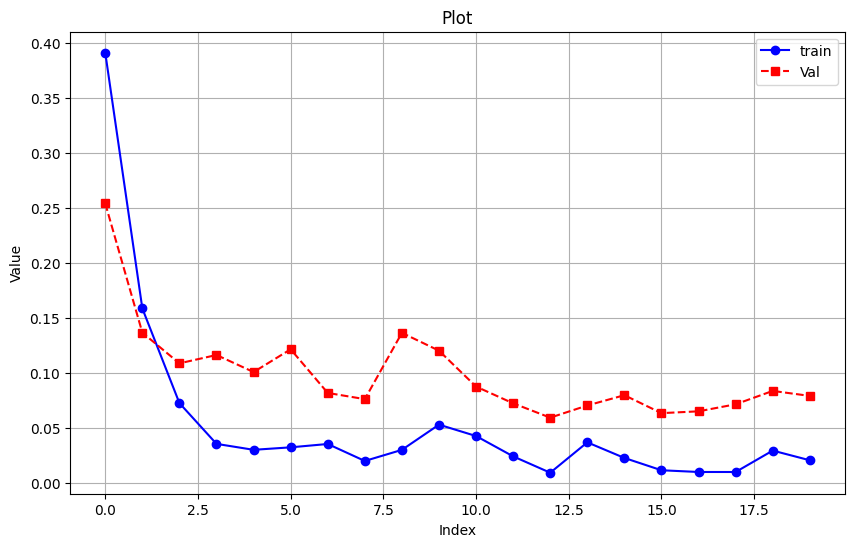

In [27]:
indices =list(range(len(train_loss)))

plt.figure(figsize=(10, 6))
plt.plot(indices, train_loss, marker='o', linestyle='-', color='b', label='train')
plt.plot(indices, val_los, marker='s', linestyle='--', color='r', label='Val')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
torch.save(model, 'model_triplet_indian.pth')

# VALİDASYON VERİSİNİN ÖZELLİKLERİ ÖN İŞLEME

In [ ]:
# model = CNNetwork()

# model.load_state_dict(torch.load('model_weights.pth'))

In [29]:
class FeatureDataset():
    def __init__(self, feature, feature_labels):
        self.data = feature
        self.labels = feature_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [30]:
model.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for anchor_img, _, _, anchor_label in val_dl:
        anchor_img = anchor_img.to(device)
        features = model(anchor_img)
        all_features.append(features)
        all_labels.append(anchor_label)





In [31]:
all_features = torch.cat(all_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)


In [ ]:
all_labels.shape

torch.Size([4288])

In [32]:
dataset = FeatureDataset(all_features, all_labels)

In [33]:
Feature_train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# TEST VERİSİNİN ÖZELLİKLERİNİ ÇIKARTMA VE ÖN İŞLEME

In [34]:
model.eval()
test_features = []
test_labels = []

with torch.no_grad():
    for anchor_img, _, _, anchor_label in test_dl:
        anchor_img = anchor_img.to(device)
        features = model(anchor_img)
        test_features.append(features)
        test_labels.append(anchor_label)

In [35]:
test_features = torch.cat(test_features, dim=0)
test_labels = torch.cat(test_labels, dim=0)

In [36]:
test_labels.shape

torch.Size([2853])

In [37]:
dataset_test = FeatureDataset(test_features, test_labels)

In [38]:
Feature_test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

# ELDE EDİLEN ÖZELLİKLER İÇİN VERİSETİ

In [39]:
classificationModel = ClassificationNN()
optimizer_feature = optim.Adam(classificationModel.parameters(), lr=0.001)
loss_for_classification = nn.CrossEntropyLoss()


In [40]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_classification(model_classification, feat_train_loader, feat_criterion, feat_optimizer, device, test_class_dl):
    model_classification.to(device)
    model_classification.train()

    loss_list = []
    epoch_accuracies = []
    evaluation_losses = []
    evaluation_accuracies = []

    for epoch in tqdm(range(20), desc="Epochs"):
        model_classification.train()
        all_labels = []
        all_predictions = []
        epoch_loss_list = []

        for inputs, labels in feat_train_loader:
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)

            feat_optimizer.zero_grad()
            outputs = model_classification(inputs)
            loss = feat_criterion(outputs, labels)
            loss.backward()
            feat_optimizer.step()

            epoch_loss_list.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions)
        epoch_accuracies.append(accuracy)
        loss_list.extend(epoch_loss_list)

        eval_loss, eval_accuracy = evaluate_classification(model_classification, test_class_dl, feat_criterion, device)
        evaluation_losses.append(eval_loss)
        evaluation_accuracies.append(eval_accuracy)

        print(f"Epoch {epoch+1}/{20}, Training Loss: {sum(epoch_loss_list)/len(epoch_loss_list):.4f}, Training Accuracy: {accuracy:.4f}")
        print(f"Validation Loss: {eval_loss:.4f}, Validation Accuracy: {eval_accuracy:.2f}%")

    return loss_list, epoch_accuracies, evaluation_losses, evaluation_accuracies


In [41]:
for param in classificationModel.parameters():
    param.requires_grad = True

In [42]:
def evaluate_classification(model, test_class_dl, clas_loss_fn, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_class_dl:
            targets= targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = clas_loss_fn(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    average_loss = total_loss / len(test_class_dl)
    accuracy = (correct / total) * 100

    return average_loss, accuracy




In [43]:
loss_list, epoch_accuracies, evaluation_losses, evaluation_accuracies = train_classification(classificationModel,Feature_train_loader,loss_for_classification,optimizer_feature,device,Feature_test_loader)

Epochs:   5%|▌         | 1/20 [00:00<00:06,  2.77it/s]

Epoch 1/20, Training Loss: 1.2530, Training Accuracy: 0.6031
Validation Loss: 0.4406, Validation Accuracy: 85.56%


Epochs:  10%|█         | 2/20 [00:00<00:06,  2.78it/s]

Epoch 2/20, Training Loss: 0.3830, Training Accuracy: 0.8710
Validation Loss: 0.2799, Validation Accuracy: 91.87%


Epochs:  15%|█▌        | 3/20 [00:01<00:05,  2.85it/s]

Epoch 3/20, Training Loss: 0.2701, Training Accuracy: 0.9076
Validation Loss: 0.2672, Validation Accuracy: 92.50%


Epochs:  20%|██        | 4/20 [00:01<00:05,  2.86it/s]

Epoch 4/20, Training Loss: 0.2241, Training Accuracy: 0.9265
Validation Loss: 0.2668, Validation Accuracy: 91.73%


Epochs:  25%|██▌       | 5/20 [00:01<00:05,  2.91it/s]

Epoch 5/20, Training Loss: 0.2110, Training Accuracy: 0.9298
Validation Loss: 0.2336, Validation Accuracy: 92.36%


Epochs:  30%|███       | 6/20 [00:02<00:04,  2.94it/s]

Epoch 6/20, Training Loss: 0.1746, Training Accuracy: 0.9419
Validation Loss: 0.2596, Validation Accuracy: 91.62%


Epochs:  35%|███▌      | 7/20 [00:02<00:04,  2.91it/s]

Epoch 7/20, Training Loss: 0.1585, Training Accuracy: 0.9480
Validation Loss: 0.1852, Validation Accuracy: 94.01%


Epochs:  40%|████      | 8/20 [00:02<00:04,  2.88it/s]

Epoch 8/20, Training Loss: 0.1590, Training Accuracy: 0.9464
Validation Loss: 0.1703, Validation Accuracy: 94.01%


Epochs:  45%|████▌     | 9/20 [00:03<00:03,  2.89it/s]

Epoch 9/20, Training Loss: 0.1235, Training Accuracy: 0.9564
Validation Loss: 0.1362, Validation Accuracy: 95.41%


Epochs:  50%|█████     | 10/20 [00:03<00:03,  2.83it/s]

Epoch 10/20, Training Loss: 0.1309, Training Accuracy: 0.9550
Validation Loss: 0.1319, Validation Accuracy: 95.76%


Epochs:  55%|█████▌    | 11/20 [00:03<00:03,  2.64it/s]

Epoch 11/20, Training Loss: 0.1221, Training Accuracy: 0.9599
Validation Loss: 0.1353, Validation Accuracy: 95.34%


Epochs:  60%|██████    | 12/20 [00:04<00:03,  2.54it/s]

Epoch 12/20, Training Loss: 0.1317, Training Accuracy: 0.9569
Validation Loss: 0.1215, Validation Accuracy: 96.18%


Epochs:  65%|██████▌   | 13/20 [00:04<00:02,  2.49it/s]

Epoch 13/20, Training Loss: 0.1188, Training Accuracy: 0.9618
Validation Loss: 0.1628, Validation Accuracy: 94.18%


Epochs:  70%|███████   | 14/20 [00:05<00:02,  2.50it/s]

Epoch 14/20, Training Loss: 0.1221, Training Accuracy: 0.9613
Validation Loss: 0.1169, Validation Accuracy: 95.44%


Epochs:  75%|███████▌  | 15/20 [00:05<00:02,  2.48it/s]

Epoch 15/20, Training Loss: 0.1033, Training Accuracy: 0.9629
Validation Loss: 0.1188, Validation Accuracy: 95.44%


Epochs:  80%|████████  | 16/20 [00:05<00:01,  2.46it/s]

Epoch 16/20, Training Loss: 0.0866, Training Accuracy: 0.9708
Validation Loss: 0.1377, Validation Accuracy: 95.27%


Epochs:  85%|████████▌ | 17/20 [00:06<00:01,  2.46it/s]

Epoch 17/20, Training Loss: 0.1118, Training Accuracy: 0.9629
Validation Loss: 0.0955, Validation Accuracy: 96.49%


Epochs:  90%|█████████ | 18/20 [00:06<00:00,  2.44it/s]

Epoch 18/20, Training Loss: 0.0765, Training Accuracy: 0.9722
Validation Loss: 0.1285, Validation Accuracy: 95.62%


Epochs:  95%|█████████▌| 19/20 [00:07<00:00,  2.47it/s]

Epoch 19/20, Training Loss: 0.0796, Training Accuracy: 0.9729
Validation Loss: 0.0804, Validation Accuracy: 96.99%


Epochs: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]

Epoch 20/20, Training Loss: 0.0786, Training Accuracy: 0.9715
Validation Loss: 0.1046, Validation Accuracy: 96.28%


In [45]:
torch.save(classificationModel,"model_classification_triplet_indian.pth")

#Değerlendirme

In [46]:
X_tensor = torch.tensor(X)
X_tensor=X_tensor.float()

y_pred_array = []
i=0
while i <  X_tensor.shape[0]:
      a =  X_tensor[i]
      a = a.unsqueeze(0)
      output=model(a)
      clas_tahmin = classificationModel(output)
      clas_tahmin =clas_tahmin.argmax().float()
      clas_tahmin=clas_tahmin.item()
      y_pred_array.append(clas_tahmin)
      i+=1




In [47]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score, f1_score


s=accuracy_score(y,y_pred_array)
c=cohen_kappa_score(y,y_pred_array)
f1=f1_score(y,y_pred_array,average='weighted')
print("Accuracy:",s)
print("Cohen Kappa Score:",c)
print("F1 Score:",f1)

Accuracy: 0.9704361401112304
Cohen Kappa Score: 0.9662690792588607
F1 Score: 0.9698079076587119


# Görselleştirme

In [48]:
gt_2=np.load('/content/drive/MyDrive/dml/indian-veriseti/IPgt.npy')

In [49]:
gt_2=gt_2.reshape(-1)

In [50]:

c=0
d=0
i=0
for i in range(21025):
    if gt_2[i] != 0:
              gt_2[i]=(y_pred_array[d] + 1)
              d += 1

gt_2=gt_2.reshape(145,-1)

In [51]:
gt_3=np.load('/content/drive/MyDrive/dml/indian-veriseti/IPgt.npy')

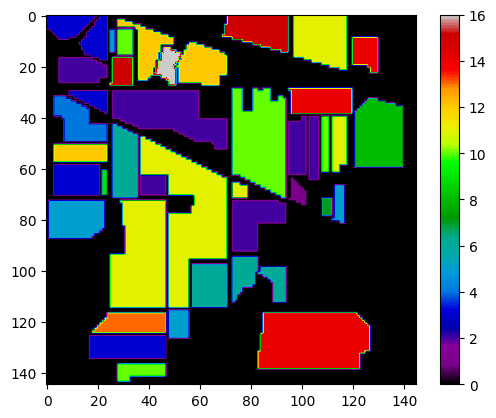

In [52]:

plt.imshow(gt_3,cmap='nipy_spectral',vmin=0, vmax=16)
plt.colorbar()

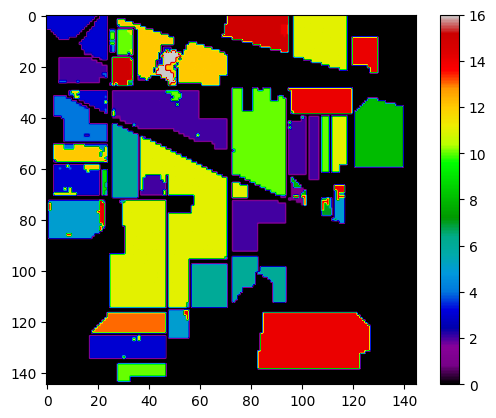

In [53]:

plt.imshow(gt_2,cmap='nipy_spectral',vmin=0, vmax=16)
plt.colorbar()